In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import src.data_utils as data_utils
import src.tree_build as dt_tree
import src.heurestics as dt_heur
import src.tree_utils as tree_utils
import src.dt_testing_utils as dt_testing
import src.tree_pruning as tree_pruning

from pprint import pprint
import numpy as np
import pandas as pd
from sklearn.utils import resample
#TODO - Add cancer

## Utils

In [3]:
def print_tree_informations(tree, training_data, testing_data):
    accuracy_testing = tree_utils.tree_accuracy(testing_data, tree)
    accuracy_training = tree_utils.tree_accuracy(training_data, tree)
    levels = tree_utils.number_of_levels(tree)
    leafs = tree_utils.number_of_leafs(tree)
    print("Accuracy for: testing {0:.2f}% | training {1:.2f}% | levels {2} | leafs {3}".format(accuracy_testing, accuracy_training,levels, leafs))

In [4]:
#heuristics
def train_and_prune_tree(heurestic, training_data, testing_data, validation_data):
    print("Before Pruning - heuristic = {0}".format(heurestic.__name__))
    trained_tree = dt_tree.build_tree_generic(heurestic, training_data)
    print_tree_informations(trained_tree, training_data, testing_data)
#     pprint(trained_tree)
    print("After Pruning:")
    pruned_trained_tree = tree_pruning.reduced_error_pruning(trained_tree, validation_data)
    print_tree_informations(pruned_trained_tree, training_data, testing_data)
    print('\n')
#     pprint(pruned_trained_tree)

In [5]:
default_heuristics = [dt_heur.gini_impurity_weighted, dt_heur.info_gain, dt_heur.information_gain_ratio,
                      dt_heur.distance_measure, dt_heur.j_measure, dt_heur.weight_of_evidence,
                      dt_heur.gini_pri, dt_heur.relief, dt_heur.relevance, dt_heur.mdl_simple]

def train_tree_for_different_heuristics(training_data, testing_data, validation_data, heuristics = default_heuristics):
    for heuristic in heuristics:
        train_and_prune_tree(heuristic, training_data, testing_data, validation_data)

# Car dataset

## Dataset preparation

In [6]:
car_dataset_path = 'data/car.data'
car_dataset_labels = ['buying','maint','doors','persons','lug_boot','safety','CLASS']
car_dataset = data_utils.preapare_dataset(car_dataset_path, car_dataset_labels)
# car_dataset.head()
car_dataset

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,med,low,4,4,small,high,good
1,vhigh,med,2,more,big,high,acc
2,med,high,4,2,small,high,unacc
3,med,low,2,4,med,high,good
4,med,high,5more,4,med,high,acc
...,...,...,...,...,...,...,...
1723,vhigh,vhigh,5more,more,small,med,unacc
1724,vhigh,med,3,2,big,med,unacc
1725,med,high,5more,2,small,high,unacc
1726,low,vhigh,3,more,small,med,unacc


### Dataset 70%

unacc    850
acc      263
good      51
vgood     45
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

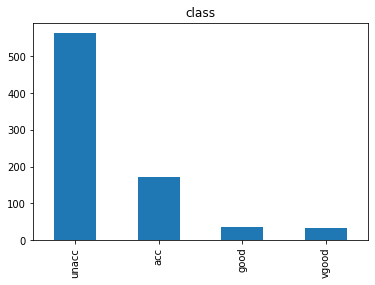

In [7]:
car_set_for_training70, car_testing70 = data_utils.data_split(car_dataset, 70)
car_training70, car_validation70 = data_utils.split_training_data_for_pruning(car_set_for_training70)
print(car_set_for_training70['CLASS'].value_counts())
car_training70['CLASS'].value_counts().plot(kind='bar', title='class')

In [8]:
car_training70

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,med,low,4,4,small,high,good
1,vhigh,med,2,more,big,high,acc
2,med,high,4,2,small,high,unacc
3,med,low,2,4,med,high,good
4,med,high,5more,4,med,high,acc
...,...,...,...,...,...,...,...
800,med,vhigh,5more,2,big,high,unacc
801,med,med,5more,2,big,med,unacc
802,vhigh,low,3,more,med,low,unacc
803,vhigh,vhigh,2,more,big,low,unacc


173


<AxesSubplot:title={'center':'class'}>

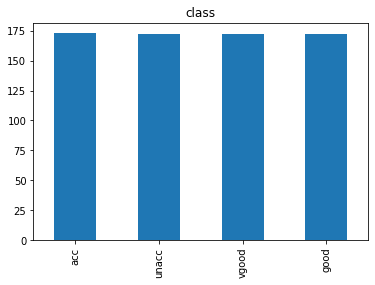

In [9]:
#Target for all 174
resampling_car70 = car_training70.copy()
unacc_part70 = resampling_car70[resampling_car70['CLASS'] == 'unacc']
acc_part70 = resampling_car70[resampling_car70['CLASS'] == 'acc'] 
print(len(acc_part70))
vgood_part70 = resampling_car70[resampling_car70['CLASS'] == 'vgood'] 
good_part70 = resampling_car70[resampling_car70['CLASS'] == 'good'] 


unacc_downsample70 = resample(unacc_part70, 
                                 replace=False,     
                                 n_samples=172)

vgood_part_upsampled70 = resample(vgood_part70, 
                                 replace=True,     
                                 n_samples=172)
good_part_upsampled70 = resample(good_part70, 
                                 replace=True,     
                                 n_samples=172)

# Combine majority class with upsamplet minority class
balanced_car_training70 = pd.concat([unacc_downsample70, acc_part70, vgood_part_upsampled70, good_part_upsampled70])
balanced_car_training70 = balanced_car_training70.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_car_training70 = balanced_car_training70.sample(frac=1).reset_index(drop=True)

car_training70 = balanced_car_training70.copy()
car_training70['CLASS'].value_counts().plot(kind='bar', title='class')

In [10]:
car_training70.head()

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,low,low,2,4,med,med,acc
1,low,high,4,4,med,high,vgood
2,low,low,5more,more,big,high,vgood
3,low,vhigh,3,more,big,med,acc
4,low,med,4,more,big,high,vgood


### Dataset 80%

unacc    968
acc      299
good      58
vgood     57
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

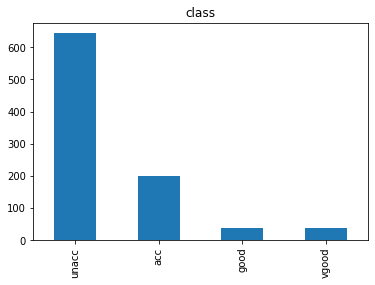

In [11]:
car_set_for_training80, car_testing80 = data_utils.data_split(car_dataset, 80)
car_training80, car_validation80 = data_utils.split_training_data_for_pruning(car_set_for_training80)
print(car_set_for_training80['CLASS'].value_counts())
car_training80['CLASS'].value_counts().plot(kind='bar', title='class')

In [12]:
car_training80

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,med,low,4,4,small,high,good
1,vhigh,med,2,more,big,high,acc
2,med,high,4,2,small,high,unacc
3,med,low,2,4,med,high,good
4,med,high,5more,4,med,high,acc
...,...,...,...,...,...,...,...
916,vhigh,low,5more,more,med,high,acc
917,vhigh,med,4,more,med,med,acc
918,med,low,5more,more,med,low,unacc
919,med,high,4,2,med,med,unacc


201


<AxesSubplot:title={'center':'class'}>

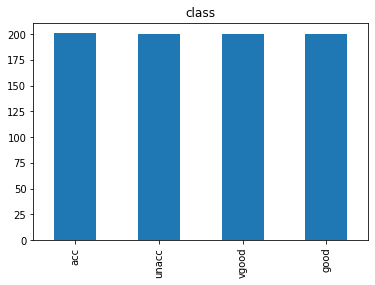

In [13]:
#Target for all 318
resampling_car80 = car_training80.copy()
unacc_part80 = resampling_car80[resampling_car80['CLASS'] == 'unacc']
acc_part80 = resampling_car80[resampling_car80['CLASS'] == 'acc'] 
print(len(acc_part80))
vgood_part80 = resampling_car80[resampling_car80['CLASS'] == 'vgood'] 
good_part80 = resampling_car80[resampling_car80['CLASS'] == 'good'] 


unacc_downsample80 = resample(unacc_part80, 
                                 replace=False,     
                                 n_samples=200)

vgood_part_upsampled80 = resample(vgood_part80, 
                                 replace=True,     
                                 n_samples=200)
good_part_upsampled80 = resample(good_part80, 
                                 replace=True,     
                                 n_samples=200)

# Combine majority class with upsamplet minority class
balanced_car_training80 = pd.concat([unacc_downsample80, acc_part80, vgood_part_upsampled80, good_part_upsampled80])
balanced_car_training80 = balanced_car_training80.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_car_training80 = balanced_car_training80.sample(frac=1).reset_index(drop=True)

car_training80 = balanced_car_training80.copy()
car_training80['CLASS'].value_counts().plot(kind='bar', title='class')

In [14]:
car_training80.head()

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,vhigh,high,2,more,big,med,unacc
1,low,med,5more,more,small,high,good
2,low,med,5more,more,med,med,good
3,vhigh,med,5more,4,small,low,unacc
4,high,low,5more,4,big,med,acc


## Model Training

### Dataset 90%

unacc    1092
acc       338
good       65
vgood      60
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

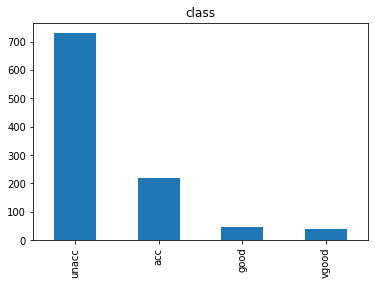

In [15]:
car_set_for_training90, car_testing90 = data_utils.data_split(car_dataset, 90)
car_training90, car_validation90 = data_utils.split_training_data_for_pruning(car_set_for_training90)
print(car_set_for_training90['CLASS'].value_counts())
car_training90['CLASS'].value_counts().plot(kind='bar', title='class')

In [16]:
# car_training90

220


<AxesSubplot:title={'center':'class'}>

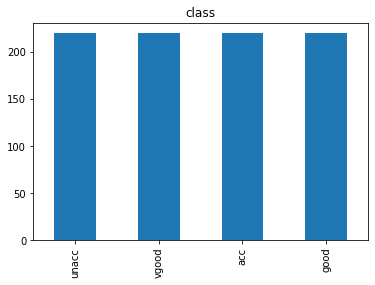

In [17]:
#Target for all 352?
resampling_car90 = car_training90.copy()
unacc_part90 = resampling_car90[resampling_car90['CLASS'] == 'unacc']
acc_part90 = resampling_car90[resampling_car90['CLASS'] == 'acc']
print(len(acc_part90))
vgood_part90 = resampling_car90[resampling_car90['CLASS'] == 'vgood'] 
good_part90 = resampling_car90[resampling_car90['CLASS'] == 'good'] 


unacc_downsample90 = resample(unacc_part90, 
                                 replace=False,     
                                 n_samples=220)

vgood_part_upsampled90 = resample(vgood_part90, 
                                 replace=True,     
                                 n_samples=220)
good_part_upsampled90 = resample(good_part90, 
                                 replace=True,     
                                 n_samples=220)

# Combine majority class with upsamplet minority class
balanced_car_training90 = pd.concat([unacc_downsample90, acc_part90, vgood_part_upsampled90, good_part_upsampled90])
balanced_car_training90 = balanced_car_training90.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_car_training90 = balanced_car_training90.sample(frac=1).reset_index(drop=True)

car_training90 = balanced_car_training90.copy()
car_training90['CLASS'].value_counts().plot(kind='bar', title='class')

In [18]:
car_training90

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,low,med,5more,4,med,med,good
1,low,vhigh,2,4,big,med,acc
2,low,high,4,more,small,med,acc
3,low,high,3,more,big,med,acc
4,vhigh,med,3,2,med,low,unacc
...,...,...,...,...,...,...,...
875,vhigh,low,4,more,big,med,acc
876,low,low,4,4,small,high,good
877,low,high,4,4,med,high,vgood
878,high,med,3,4,small,high,acc


In [19]:
# trained_tree_car = dt_tree.build_tree_generic(dt_heur.information_gain_ratio, car_training)

In [20]:
# # print(trained_tree_car)
# pprint(trained_tree_car)

In [21]:
train_tree_for_different_heuristics(car_training70, car_testing70, car_validation70)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 53.95% | training 70.10% | levels 10 | leafs 31
After Pruning:
Accuracy for: testing 65.70% | training 62.26% | levels 10 | leafs 16


Before Pruning - heuristic = info_gain
Accuracy for: testing 53.37% | training 71.41% | levels 10 | leafs 31
After Pruning:
Accuracy for: testing 63.39% | training 61.39% | levels 10 | leafs 9


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 49.13% | training 69.09% | levels 10 | leafs 32
After Pruning:
Accuracy for: testing 65.13% | training 56.89% | levels 10 | leafs 13


Before Pruning - heuristic = distance_measure
Accuracy for: testing 42.58% | training 55.73% | levels 10 | leafs 32
After Pruning:
Accuracy for: testing 66.09% | training 32.51% | levels 10 | leafs 12


Before Pruning - heuristic = j_measure
Accuracy for: testing 54.53% | training 73.00% | levels 10 | leafs 32
After Pruning:
Accuracy for: testing 65.51% | training 58.35% | levels 10 |

In [22]:
train_tree_for_different_heuristics(car_training80, car_testing80, car_validation80)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 46.82% | training 69.41% | levels 10 | leafs 31
After Pruning:
Accuracy for: testing 62.72% | training 61.30% | levels 10 | leafs 15


Before Pruning - heuristic = info_gain
Accuracy for: testing 56.36% | training 73.16% | levels 10 | leafs 31
After Pruning:
Accuracy for: testing 69.65% | training 64.79% | levels 10 | leafs 16


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 49.13% | training 69.29% | levels 10 | leafs 32
After Pruning:
Accuracy for: testing 63.29% | training 55.81% | levels 10 | leafs 11


Before Pruning - heuristic = distance_measure
Accuracy for: testing 41.33% | training 56.43% | levels 10 | leafs 32
After Pruning:
Accuracy for: testing 66.18% | training 33.21% | levels 10 | leafs 14


Before Pruning - heuristic = j_measure
Accuracy for: testing 55.78% | training 73.03% | levels 10 | leafs 31
After Pruning:
Accuracy for: testing 69.08% | training 64.67% | levels 10 

In [23]:
train_tree_for_different_heuristics(car_training90, car_testing90, car_validation90)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 41.04% | training 68.30% | levels 10 | leafs 31
After Pruning:
Accuracy for: testing 60.69% | training 54.20% | levels 10 | leafs 12


Before Pruning - heuristic = info_gain
Accuracy for: testing 43.35% | training 66.36% | levels 10 | leafs 31
After Pruning:
Accuracy for: testing 60.69% | training 53.98% | levels 10 | leafs 12


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 46.82% | training 73.86% | levels 10 | leafs 32
After Pruning:
Accuracy for: testing 64.74% | training 62.84% | levels 10 | leafs 17


Before Pruning - heuristic = distance_measure
Accuracy for: testing 45.66% | training 52.05% | levels 10 | leafs 32
After Pruning:
Accuracy for: testing 60.69% | training 34.20% | levels 10 | leafs 15


Before Pruning - heuristic = j_measure
Accuracy for: testing 53.18% | training 71.70% | levels 10 | leafs 31
After Pruning:
Accuracy for: testing 68.21% | training 62.27% | levels 10 

# Cancer Dataset

# Dataset preparation

In [24]:
cancer_dataset_path = 'data/breast-cancer.data'
cancer_dataset_labels = ['CLASS','age','menopause','tumor-size','inv-nodes','node-caps','deg-malig','breast', 'breast-quad', 'irradiat']
cancer_dataset = data_utils.preapare_dataset(cancer_dataset_path, cancer_dataset_labels)
cancer_dataset = cancer_dataset[['age','menopause','tumor-size','inv-nodes', 'node-caps','deg-malig','breast', 'breast-quad', 'irradiat', 'CLASS']]
# cancer_dataset.head()
cancer_dataset

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,CLASS
0,40-49,premeno,30-34,0-2,no,3,right,right_up,no,no-recurrence-events
1,50-59,ge40,25-29,0-2,no,3,left,right_up,no,no-recurrence-events
2,50-59,ge40,30-34,0-2,no,1,right,left_low,no,no-recurrence-events
3,40-49,premeno,50-54,0-2,no,2,right,left_low,yes,recurrence-events
4,30-39,premeno,20-24,3-5,no,2,right,central,no,no-recurrence-events
...,...,...,...,...,...,...,...,...,...,...
281,40-49,premeno,0-4,0-2,no,2,right,right_low,no,no-recurrence-events
282,40-49,premeno,5-9,0-2,no,1,left,left_low,yes,no-recurrence-events
283,40-49,premeno,30-34,0-2,no,1,left,left_low,yes,recurrence-events
284,50-59,premeno,20-24,0-2,no,1,left,left_low,no,no-recurrence-events


### Cancer 70%

no-recurrence-events    87
recurrence-events       46
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

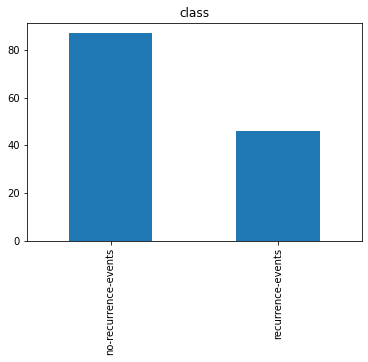

In [25]:
cancer_set_for_training70, cancer_testing70 = data_utils.data_split(cancer_dataset, 70)
cancer_training70, cancer_validation70 = data_utils.split_training_data_for_pruning(cancer_set_for_training70)
print(cancer_training70['CLASS'].value_counts())
cancer_training70['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

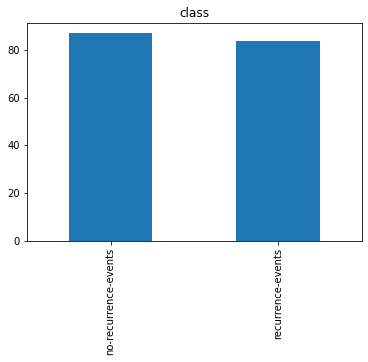

In [26]:
#Target for all 174
resampling_cancer70 = cancer_training70.copy()
recurrence_events_part70 = resampling_cancer70[resampling_cancer70['CLASS'] == 'recurrence-events']
no_recurrence_events_part70 = resampling_cancer70[resampling_cancer70['CLASS'] == 'no-recurrence-events'] 

recurrence_events_part_upsampled70 = resample(recurrence_events_part70, 
                                 replace=True,     
                                 n_samples=84)

# Combine majority class with upsamplet minority class
balanced_cnacer_training70 = pd.concat([recurrence_events_part_upsampled70, no_recurrence_events_part70])
balanced_cnacer_training70 = balanced_cnacer_training70.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_cnacer_training70 = balanced_cnacer_training70.sample(frac=1).reset_index(drop=True)

cancer_training70 = balanced_cnacer_training70.copy()
cancer_training70['CLASS'].value_counts().plot(kind='bar', title='class')

### Cancer 80%

no-recurrence-events    97
recurrence-events       54
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

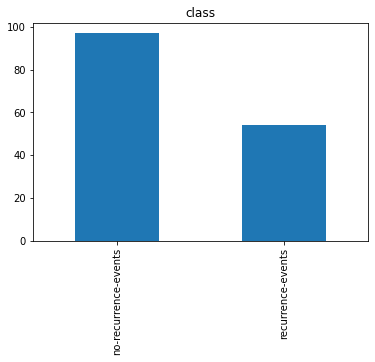

In [27]:
cancer_set_for_training80, cancer_testing80 = data_utils.data_split(cancer_dataset, 80)
cancer_training80, cancer_validation80 = data_utils.split_training_data_for_pruning(cancer_set_for_training80)
print(cancer_training80['CLASS'].value_counts())
cancer_training80['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

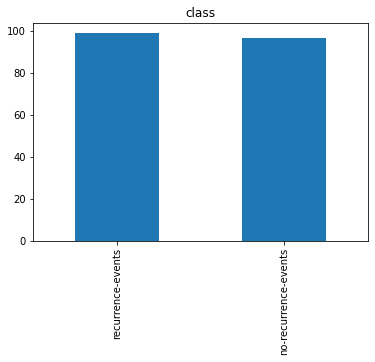

In [28]:
#Target for all 174
resampling_cancer80 = cancer_training80.copy()
recurrence_events_part80 = resampling_cancer80[resampling_cancer80['CLASS'] == 'recurrence-events']
no_recurrence_events_part80 = resampling_cancer80[resampling_cancer80['CLASS'] == 'no-recurrence-events'] 

recurrence_events_part_upsampled80 = resample(recurrence_events_part80, 
                                 replace=True,     
                                 n_samples=99)

# Combine majority class with upsamplet minority class
balanced_cnacer_training80 = pd.concat([recurrence_events_part_upsampled80, no_recurrence_events_part80])
balanced_cnacer_training80 = balanced_cnacer_training80.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_cnacer_training80 = balanced_cnacer_training80.sample(frac=1).reset_index(drop=True)

cancer_training80 = balanced_cnacer_training80.copy()
cancer_training80['CLASS'].value_counts().plot(kind='bar', title='class')

### Cancer 90%

no-recurrence-events    114
recurrence-events        57
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

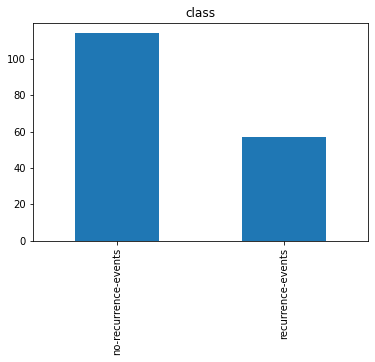

In [29]:
cancer_set_for_training90, cancer_testing90 = data_utils.data_split(cancer_dataset, 90)
cancer_training90, cancer_validation90 = data_utils.split_training_data_for_pruning(cancer_set_for_training90)
print(cancer_training90['CLASS'].value_counts())
cancer_training90['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

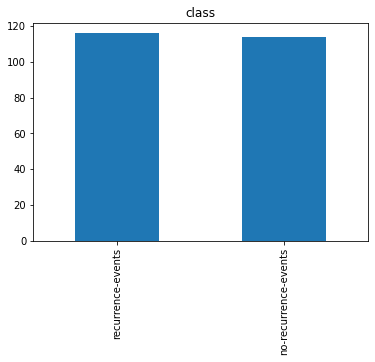

In [30]:

#Target for all 174
resampling_cancer90 = cancer_training90.copy()
recurrence_events_part90 = resampling_cancer90[resampling_cancer90['CLASS'] == 'recurrence-events']
no_recurrence_events_part90 = resampling_cancer90[resampling_cancer90['CLASS'] == 'no-recurrence-events'] 

recurrence_events_part_upsampled90 = resample(recurrence_events_part90, 
                                 replace=True,     
                                 n_samples=116)

# Combine majority class with upsamplet minority class
balanced_cnacer_training90 = pd.concat([recurrence_events_part_upsampled90, no_recurrence_events_part90])
balanced_cnacer_training90 = balanced_cnacer_training90.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_cnacer_training90 = balanced_cnacer_training90.sample(frac=1).reset_index(drop=True)

cancer_training90 = balanced_cnacer_training90.copy()
cancer_training90['CLASS'].value_counts().plot(kind='bar', title='class')

## Model Training

In [31]:
train_tree_for_different_heuristics(cancer_training70, cancer_testing70, cancer_validation70)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 58.14% | training 92.40% | levels 18 | leafs 47
After Pruning:
Accuracy for: testing 70.93% | training 71.93% | levels 4 | leafs 3


Before Pruning - heuristic = info_gain
Accuracy for: testing 62.79% | training 94.74% | levels 18 | leafs 46
After Pruning:
Accuracy for: testing 72.09% | training 74.85% | levels 14 | leafs 11


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 65.12% | training 95.91% | levels 18 | leafs 45
After Pruning:
Accuracy for: testing 75.58% | training 74.27% | levels 14 | leafs 10


Before Pruning - heuristic = distance_measure
Accuracy for: testing 40.70% | training 84.21% | levels 16 | leafs 48
After Pruning:
Accuracy for: testing 60.47% | training 60.23% | levels 14 | leafs 16


Before Pruning - heuristic = j_measure
Accuracy for: testing 59.30% | training 93.57% | levels 18 | leafs 51
After Pruning:
Accuracy for: testing 66.28% | training 82.46% | levels 18 | 

In [32]:
train_tree_for_different_heuristics(cancer_training80, cancer_testing80, cancer_validation80)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 55.17% | training 93.88% | levels 18 | leafs 50
After Pruning:
Accuracy for: testing 70.69% | training 72.96% | levels 16 | leafs 13


Before Pruning - heuristic = info_gain
Accuracy for: testing 50.00% | training 92.35% | levels 18 | leafs 42
After Pruning:
Accuracy for: testing 62.07% | training 79.08% | levels 18 | leafs 17


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 58.62% | training 95.92% | levels 18 | leafs 38
After Pruning:
Accuracy for: testing 74.14% | training 71.94% | levels 14 | leafs 10


Before Pruning - heuristic = distance_measure
Accuracy for: testing 39.66% | training 78.06% | levels 16 | leafs 38
After Pruning:
Accuracy for: testing 53.45% | training 63.78% | levels 16 | leafs 15


Before Pruning - heuristic = j_measure
Accuracy for: testing 56.90% | training 95.41% | levels 18 | leafs 49
After Pruning:
Accuracy for: testing 68.97% | training 82.65% | levels 16 

In [33]:
train_tree_for_different_heuristics(cancer_training90, cancer_testing90, cancer_validation90)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 65.52% | training 89.57% | levels 18 | leafs 41
After Pruning:
Accuracy for: testing 72.41% | training 72.17% | levels 10 | leafs 11


Before Pruning - heuristic = info_gain
Accuracy for: testing 65.52% | training 93.04% | levels 18 | leafs 53
After Pruning:
Accuracy for: testing 68.97% | training 79.13% | levels 18 | leafs 29


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 65.52% | training 93.91% | levels 18 | leafs 41
After Pruning:
Accuracy for: testing 79.31% | training 64.35% | levels 10 | leafs 6


Before Pruning - heuristic = distance_measure
Accuracy for: testing 41.38% | training 88.70% | levels 16 | leafs 61
After Pruning:
Accuracy for: testing 72.41% | training 59.13% | levels 16 | leafs 13


Before Pruning - heuristic = j_measure
Accuracy for: testing 72.41% | training 93.48% | levels 18 | leafs 52
After Pruning:
Accuracy for: testing 75.86% | training 70.87% | levels 18 |

# CMC Dataset

## Dataset preparation

In [34]:
cmc_dataset_path = 'data/cmc.data'
cmc_dataset_labels = ['age','education','husbandEducation','noChildren','religion','isWorking','husbandOccupation','livingStandard', 'mediaExposure', 'CLASS']
cmc_dataset = data_utils.preapare_dataset(cmc_dataset_path, cmc_dataset_labels)
# cmc_dataset['CLASS'] = cmc_dataset['CLASS'].apply(str)
# cmc_dataset.head()
cmc_dataset

,age,education,husbandEducation,noChildren,religion,isWorking,husbandOccupation,livingStandard,mediaExposure,CLASS
0,37,4,4,3,1,1,3,4,0,2
1,35,4,4,5,1,0,1,3,0,2
2,48,1,1,8,1,0,2,2,1,1
3,24,2,4,2,1,1,3,4,0,1
4,23,3,3,2,1,1,2,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1468,43,4,4,5,0,1,1,4,0,3
1469,31,3,3,1,1,0,3,4,0,1
1470,26,2,3,1,1,0,3,4,1,1
1471,27,3,3,3,1,1,2,3,0,3


In [35]:
vals_to_replace_education = {1: 'low', 2:'medium', 3:'normal', 4:'high'}
vals_to_replace_husbandEducation = {1: 'low', 2:'medium', 3:'normal', 4:'high'}
vals_to_replace_religion = {0: 'Non-Islam', 1:'Islam'}
vals_to_replace_isWorking = {0: 'Yes', 1:'No'}
vals_to_replace_livingStandard= {1: 'low', 2:'medium', 3:'normal', 4:'high'}
vals_to_replace_mediaExposure = {0: 'Good', 1:'Not good'}
vals_to_replace_CLASS = {1: 'No-use', 2:'Long-term', 3: 'Short-term'}
cmc_dataset['education'] = cmc_dataset['education'].map(vals_to_replace_education)
cmc_dataset['husbandEducation'] = cmc_dataset['husbandEducation'].map(vals_to_replace_husbandEducation)
cmc_dataset['religion'] = cmc_dataset['religion'].map(vals_to_replace_religion)
cmc_dataset['isWorking'] = cmc_dataset['isWorking'].map(vals_to_replace_isWorking)
cmc_dataset['livingStandard'] = cmc_dataset['livingStandard'].map(vals_to_replace_livingStandard)
cmc_dataset['mediaExposure'] = cmc_dataset['mediaExposure'].map(vals_to_replace_mediaExposure)
cmc_dataset['CLASS'] = cmc_dataset['CLASS'].map(vals_to_replace_CLASS)

In [36]:
# cmc_dataset.head()
cmc_dataset

,age,education,husbandEducation,noChildren,religion,isWorking,husbandOccupation,livingStandard,mediaExposure,CLASS
0,37,high,high,3,Islam,No,3,high,Good,Long-term
1,35,high,high,5,Islam,Yes,1,normal,Good,Long-term
2,48,low,low,8,Islam,Yes,2,medium,Not good,No-use
3,24,medium,high,2,Islam,No,3,high,Good,No-use
4,23,normal,normal,2,Islam,No,2,medium,Good,No-use
...,...,...,...,...,...,...,...,...,...,...
1468,43,high,high,5,Non-Islam,No,1,high,Good,Short-term
1469,31,normal,normal,1,Islam,Yes,3,high,Good,No-use
1470,26,medium,normal,1,Islam,Yes,3,high,Not good,No-use
1471,27,normal,normal,3,Islam,No,2,normal,Good,Short-term


### Cmc 70%

No-use        316
Short-term    218
Long-term     153
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

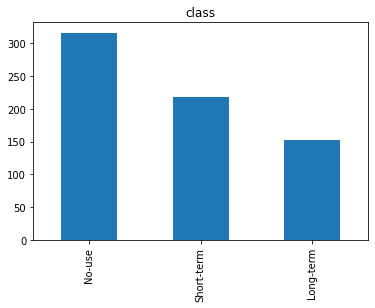

In [37]:
cmc_set_for_training70, cmc_testing70 = data_utils.data_split(cmc_dataset, 70)
cmc_training70, cmc_validation70 = data_utils.split_training_data_for_pruning(cmc_set_for_training70)
print(cmc_training70['CLASS'].value_counts())
#This data seems to be balanced so dont need aditional balancing
cmc_training70['CLASS'].value_counts().plot(kind='bar', title='class')

## Cmc 80%

No-use        355
Short-term    255
Long-term     175
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

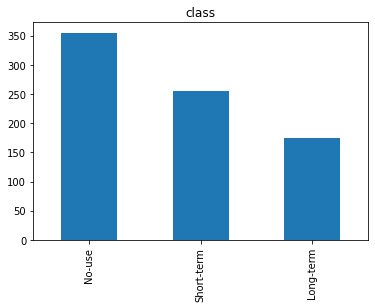

In [38]:
cmc_set_for_training80, cmc_testing80 = data_utils.data_split(cmc_dataset, 80)
cmc_training80, cmc_validation80 = data_utils.split_training_data_for_pruning(cmc_set_for_training80)
print(cmc_training80['CLASS'].value_counts())
#This data seems to be balanced so dont need aditional balancing
cmc_training80['CLASS'].value_counts().plot(kind='bar', title='class')

## Cmc 90%

No-use        389
Short-term    296
Long-term     198
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

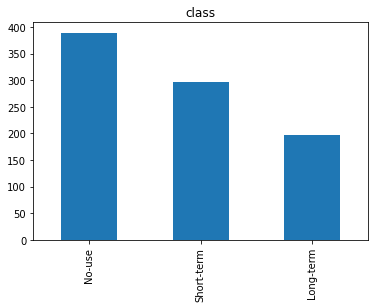

In [39]:
cmc_set_for_training90, cmc_testing90 = data_utils.data_split(cmc_dataset, 90)
cmc_training90, cmc_validation90 = data_utils.split_training_data_for_pruning(cmc_set_for_training90)
print(cmc_training90['CLASS'].value_counts())
#This data seems to be balanced so dont need aditional balancing
cmc_training90['CLASS'].value_counts().plot(kind='bar', title='class')

## Model Training

In [40]:
train_tree_for_different_heuristics(cmc_training70, cmc_testing70, cmc_validation70)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 46.83% | training 80.06% | levels 28 | leafs 169
After Pruning:
Accuracy for: testing 54.52% | training 63.90% | levels 28 | leafs 52


Before Pruning - heuristic = info_gain
Accuracy for: testing 44.34% | training 70.31% | levels 38 | leafs 183
After Pruning:
Accuracy for: testing 43.44% | training 52.55% | levels 34 | leafs 71


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 46.38% | training 70.74% | levels 38 | leafs 191
After Pruning:
Accuracy for: testing 44.57% | training 54.29% | levels 36 | leafs 87


Before Pruning - heuristic = distance_measure
Accuracy for: testing 41.40% | training 57.06% | levels 36 | leafs 170
After Pruning:
Accuracy for: testing 41.18% | training 50.22% | levels 30 | leafs 49


Before Pruning - heuristic = j_measure
Accuracy for: testing 44.57% | training 70.16% | levels 38 | leafs 183
After Pruning:
Accuracy for: testing 43.44% | training 52.69% | level

In [41]:
train_tree_for_different_heuristics(cmc_training80, cmc_testing80, cmc_validation80)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 49.15% | training 77.96% | levels 26 | leafs 171
After Pruning:
Accuracy for: testing 55.93% | training 58.60% | levels 24 | leafs 36


Before Pruning - heuristic = info_gain
Accuracy for: testing 44.41% | training 65.61% | levels 40 | leafs 178
After Pruning:
Accuracy for: testing 45.76% | training 51.08% | levels 38 | leafs 70


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 48.81% | training 65.86% | levels 42 | leafs 187
After Pruning:
Accuracy for: testing 47.80% | training 54.27% | levels 42 | leafs 103


Before Pruning - heuristic = distance_measure
Accuracy for: testing 42.03% | training 57.45% | levels 32 | leafs 170
After Pruning:
Accuracy for: testing 45.08% | training 51.08% | levels 26 | leafs 62


Before Pruning - heuristic = j_measure
Accuracy for: testing 43.05% | training 65.10% | levels 40 | leafs 178
After Pruning:
Accuracy for: testing 44.75% | training 50.83% | leve

In [42]:

train_tree_for_different_heuristics(cmc_training90, cmc_testing90, cmc_validation90)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 47.97% | training 75.31% | levels 32 | leafs 173
After Pruning:
Accuracy for: testing 55.41% | training 60.59% | levels 22 | leafs 50


Before Pruning - heuristic = info_gain
Accuracy for: testing 44.59% | training 64.33% | levels 36 | leafs 181
After Pruning:
Accuracy for: testing 46.62% | training 52.89% | levels 34 | leafs 103


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 50.00% | training 63.99% | levels 38 | leafs 189
After Pruning:
Accuracy for: testing 46.62% | training 52.43% | levels 34 | leafs 101


Before Pruning - heuristic = distance_measure
Accuracy for: testing 47.97% | training 54.81% | levels 36 | leafs 183
After Pruning:
Accuracy for: testing 51.35% | training 50.96% | levels 36 | leafs 99


Before Pruning - heuristic = j_measure
Accuracy for: testing 46.62% | training 63.65% | levels 36 | leafs 179
After Pruning:
Accuracy for: testing 46.62% | training 53.11% | lev

# Adult Dataset

## Data preparation

In [43]:
adult_dataset_path = 'data/adult.data'
adult_dataset_labels = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hourse-per-week','native-country','CLASS']
adult_dataset = data_utils.preapare_dataset(adult_dataset_path, adult_dataset_labels)
adult_dataset.head()
# adult_dataset

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hourse-per-week,native-country,CLASS
0,23,Self-emp-not-inc,289116,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,0,50,United-States,<=50K
1,41,?,202822,HS-grad,9,Separated,?,Not-in-family,Black,Female,0,0,32,United-States,<=50K
2,41,Private,170866,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K
3,38,Self-emp-not-inc,261382,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
4,29,Self-emp-inc,124950,Bachelors,13,Never-married,Sales,Own-child,White,Female,0,0,40,United-States,<=50K


In [44]:
adult_dataset = adult_dataset[['age','workclass','education','education-num','marital-status','occupation','relationship','race','sex','hourse-per-week', 'native-country' ,'CLASS']]

for element in list(adult_dataset):
    if adult_dataset[element].dtype not in [np.float64, np.int64]:
        adult_dataset[element] = adult_dataset[element].str.strip()

adult_dataset['CLASS'] = adult_dataset['CLASS'].str.strip()
adult_dataset.head()
adult_dataset

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hourse-per-week,native-country,CLASS
0,23,Self-emp-not-inc,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,50,United-States,<=50K
1,41,?,HS-grad,9,Separated,?,Not-in-family,Black,Female,32,United-States,<=50K
2,41,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,50,United-States,>50K
3,38,Self-emp-not-inc,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,40,United-States,<=50K
4,29,Self-emp-inc,Bachelors,13,Never-married,Sales,Own-child,White,Female,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,28,Private,Some-college,10,Never-married,Adm-clerical,Unmarried,Black,Female,40,United-States,<=50K
32557,49,Private,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,60,United-States,<=50K
32558,29,Private,Some-college,10,Never-married,Handlers-cleaners,Not-in-family,White,Male,35,United-States,<=50K
32559,44,Private,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,60,United-States,>50K


In [45]:
adult_dataset.dropna(how='any', axis=0)
indexNames = adult_dataset[(adult_dataset['workclass'] == '?') | (adult_dataset['education'] == '?') | (adult_dataset['marital-status'] == '?') | (adult_dataset['occupation'] == '?') | (adult_dataset['relationship'] == '?') | (adult_dataset['race'] == '?') | (adult_dataset['sex'] == '?') | (adult_dataset['native-country'] == '?') ].index
# print(indexNames)
adult_dataset.drop(indexNames, inplace=True)
adult_dataset.head()
adult_dataset.reset_index(inplace=False)
adult_dataset

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hourse-per-week,native-country,CLASS
0,23,Self-emp-not-inc,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,50,United-States,<=50K
2,41,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,50,United-States,>50K
3,38,Self-emp-not-inc,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,40,United-States,<=50K
4,29,Self-emp-inc,Bachelors,13,Never-married,Sales,Own-child,White,Female,40,United-States,<=50K
5,33,Private,Assoc-acdm,12,Divorced,Machine-op-inspct,Unmarried,Amer-Indian-Eskimo,Female,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,28,Private,Some-college,10,Never-married,Adm-clerical,Unmarried,Black,Female,40,United-States,<=50K
32557,49,Private,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,60,United-States,<=50K
32558,29,Private,Some-college,10,Never-married,Handlers-cleaners,Not-in-family,White,Male,35,United-States,<=50K
32559,44,Private,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,60,United-States,>50K


In [46]:
# adult_dataset['education-num'].where(adult_dataset['education-num'] > 10)

### Adult 70%

<=50K    10541
>50K      3534
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

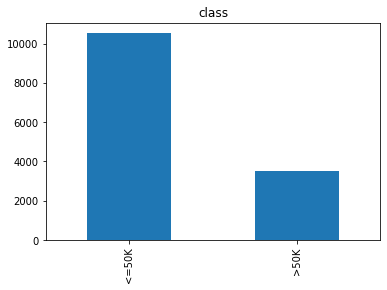

In [47]:
adult_set_for_training70, adult_testing70 = data_utils.data_split(adult_dataset, 70)
adult_training70, adult_validation70 = data_utils.split_training_data_for_pruning(adult_set_for_training70)

print(adult_training70['CLASS'].value_counts())
adult_training70['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

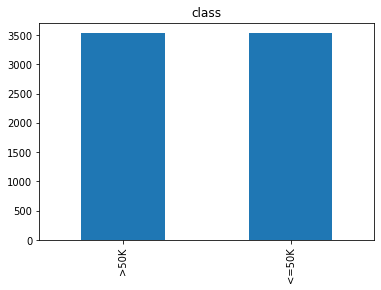

In [48]:
resampling_adult70 = adult_training70.copy()
less_50k_part70 = resampling_adult70[resampling_adult70['CLASS'] == '<=50K']
more_50k_part70 = resampling_adult70[resampling_adult70['CLASS'] == '>50K'] 

less_50k_part_downsampled70 = resample(less_50k_part70, 
                                 replace=False,    
                                 n_samples=3528)

# Combine minority class with downsampled majority class
balanced_adult_training70 = pd.concat([less_50k_part_downsampled70, more_50k_part70])
balanced_adult_training70 = balanced_adult_training70.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_adult_training70 = balanced_adult_training70.sample(frac=1).reset_index(drop=True)

adult_training70 = balanced_adult_training70.copy()
adult_training70['CLASS'].value_counts().plot(kind='bar', title='class')

### Adult 80%

<=50K    12046
>50K      4039
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

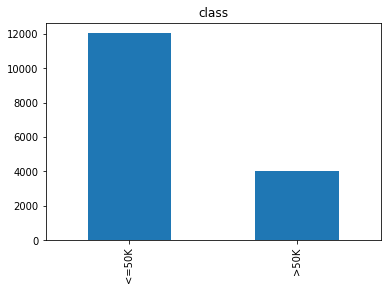

In [49]:
adult_set_for_training80, adult_testing80 = data_utils.data_split(adult_dataset, 80)
adult_training80, adult_validation80 = data_utils.split_training_data_for_pruning(adult_set_for_training80)

print(adult_training80['CLASS'].value_counts())
adult_training80['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

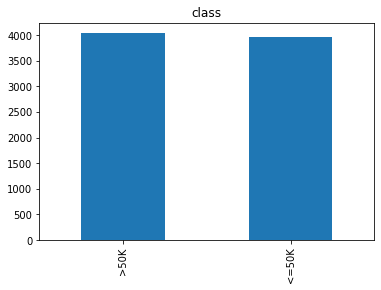

In [50]:
resampling_adult80 = adult_training80.copy()
less_50k_part80 = resampling_adult80[resampling_adult80['CLASS'] == '<=50K']
more_50k_part80 = resampling_adult80[resampling_adult80['CLASS'] == '>50K'] 

less_50k_part_downsampled80 = resample(less_50k_part80, 
                                 replace=False,    
                                 n_samples=3955)

# Combine minority class with downsampled majority class
balanced_adult_training80 = pd.concat([less_50k_part_downsampled80, more_50k_part80])
balanced_adult_training80 = balanced_adult_training80.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_adult_training80 = balanced_adult_training80.sample(frac=1).reset_index(drop=True)

adult_training80 = balanced_adult_training80.copy()
adult_training80['CLASS'].value_counts().plot(kind='bar', title='class')

### Adult 90%

<=50K    13568
>50K      4528
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

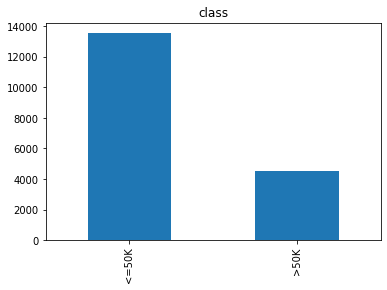

In [51]:
adult_set_for_training90, adult_testing90 = data_utils.data_split(adult_dataset, 90)
adult_training90, adult_validation90 = data_utils.split_training_data_for_pruning(adult_set_for_training90)

print(adult_training90['CLASS'].value_counts())
adult_training90['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

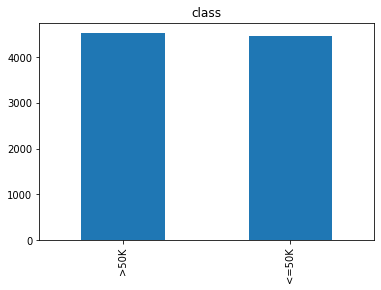

In [52]:
resampling_adult90 = adult_training90.copy()
less_50k_part90 = resampling_adult90[resampling_adult90['CLASS'] == '<=50K']
more_50k_part90 = resampling_adult90[resampling_adult90['CLASS'] == '>50K'] 

less_50k_part_downsampled90 = resample(less_50k_part90, 
                                 replace=False,    
                                 n_samples=4469)

# Combine minority class with downsampled majority class
balanced_adult_training90 = pd.concat([less_50k_part_downsampled90, more_50k_part90])
balanced_adult_training90 = balanced_adult_training90.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_adult_training90 = balanced_adult_training90.sample(frac=1).reset_index(drop=True)

adult_training90 = balanced_adult_training90.copy()
adult_training90['CLASS'].value_counts().plot(kind='bar', title='class')

## Model Training

In [53]:
train_tree_for_different_heuristics(adult_training70, adult_testing70, adult_validation70)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 77.67% | training 82.48% | levels 48 | leafs 233
After Pruning:
Accuracy for: testing 81.43% | training 78.72% | levels 40 | leafs 57


Before Pruning - heuristic = info_gain
Accuracy for: testing 65.50% | training 72.29% | levels 100 | leafs 257
After Pruning:
Accuracy for: testing 74.77% | training 50.47% | levels 8 | leafs 5


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 65.65% | training 71.85% | levels 100 | leafs 264
After Pruning:
Accuracy for: testing 74.77% | training 50.47% | levels 8 | leafs 5


Before Pruning - heuristic = distance_measure
Accuracy for: testing 72.22% | training 76.61% | levels 62 | leafs 247
After Pruning:
Accuracy for: testing 81.01% | training 74.31% | levels 62 | leafs 111


Before Pruning - heuristic = j_measure
Accuracy for: testing 65.50% | training 72.29% | levels 100 | leafs 259
After Pruning:
Accuracy for: testing 74.77% | training 50.47% | level

In [54]:
train_tree_for_different_heuristics(adult_training80, adult_testing80, adult_validation80)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 76.83% | training 82.57% | levels 38 | leafs 240
After Pruning:
Accuracy for: testing 82.05% | training 78.45% | levels 38 | leafs 63


Before Pruning - heuristic = info_gain
Accuracy for: testing 65.22% | training 72.24% | levels 106 | leafs 276
After Pruning:
Accuracy for: testing 74.21% | training 50.76% | levels 18 | leafs 10


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 65.06% | training 71.53% | levels 106 | leafs 282
After Pruning:
Accuracy for: testing 74.21% | training 50.76% | levels 18 | leafs 10


Before Pruning - heuristic = distance_measure
Accuracy for: testing 76.50% | training 77.42% | levels 64 | leafs 301
After Pruning:
Accuracy for: testing 80.81% | training 72.48% | levels 52 | leafs 110


Before Pruning - heuristic = j_measure
Accuracy for: testing 65.22% | training 72.24% | levels 106 | leafs 276
After Pruning:
Accuracy for: testing 74.21% | training 50.76% | l

In [55]:
train_tree_for_different_heuristics(adult_training90, adult_testing90, adult_validation90)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 75.87% | training 82.38% | levels 46 | leafs 231
After Pruning:
Accuracy for: testing 80.84% | training 79.12% | levels 46 | leafs 118


Before Pruning - heuristic = info_gain
Accuracy for: testing 65.73% | training 72.27% | levels 98 | leafs 264
After Pruning:
Accuracy for: testing 74.61% | training 50.63% | levels 32 | leafs 23


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 65.33% | training 71.90% | levels 98 | leafs 265
After Pruning:
Accuracy for: testing 74.61% | training 50.63% | levels 32 | leafs 23


Before Pruning - heuristic = distance_measure
Accuracy for: testing 73.85% | training 78.06% | levels 74 | leafs 307
After Pruning:
Accuracy for: testing 79.09% | training 73.19% | levels 60 | leafs 110


Before Pruning - heuristic = j_measure
Accuracy for: testing 65.59% | training 72.30% | levels 98 | leafs 268
After Pruning:
Accuracy for: testing 74.61% | training 50.63% | lev